In [2]:
%pylab inline
import ML

Populating the interactive namespace from numpy and matplotlib


# COMP 598 - Lecture 3: Linear regression (Cont.)

This lecture is a continuation of the last, it also includes playing with some code that is now in ML.py

To have a unique solution, $X^TX$ needs to be non-singular/invertible (i.e full column rank or no correlation between features). It can be difficult dealing with $(X^TX)^{-1}$ in the following two cases: 

1. The weights are not uniquely defined. This means that we would need to recode or drop some of the redundant columns of $X$.
2. The number of features/weights (m) exceeds the number of training examples (n). To solve this we need to reduce the number of features.

## More features
If we have the original set of features as $X_1, \ldots, X_m$ we can increase the number of features using the following methods:

1. Numeric coding / binary coding

2. Interaction terms between two or more features $X_{m+1} = X_iX_j

3. Basis expansions, power expansions, $X_{m+1} = x_i^2$

4. Non-linear transformations of variables. $X_{m+1} = \log(X_i)$

## Linear Regression with polynomial terms

How can we investigate a hypothesis such as $f_w(x) = w_0 + w_1 x + w_2 x^2$?

Consider our previous data set

In [3]:
x = [ 0.86, 0.09, -0.85 , 0.87, -0.44, -0.43, -1.10 , 0.40, -0.96 , 0.17 ]
y =  [ 2.49 , 0.83, -0.25 , 3.10 , 0.87 , 0.02, -0.12 , 1.81, -0.83,  0.43 ]

What if this data can be better fit with a second order polynomial versus a first order polynomial? 

Let us now add a new feature which is just the square of the first feature making our hypothesis: $f_w(x) = w_0 + w_1 x + w_2x^2$.

In [4]:
x2 = np.array(x)**2
# putting it into matrix form:
data = np.matrix( [x, x2] ).T
labels = np.matrix( y ).T

In [5]:
X = ML.add_bias_term(data)
Y = labels

In [6]:
w_estimates = ML.least_squares(X,Y) #conduct least squares to obtain weight estimates

In [7]:
h = ML.Hypothesis.linear(w_estimates) #our hypothesis

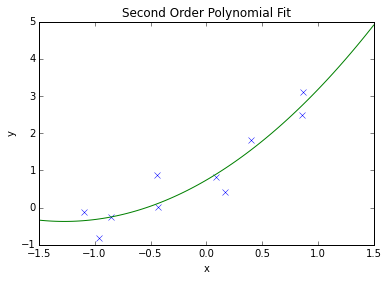

In [8]:
plt.plot(x, y, 'x')

# plotting our line of fit.
x_axis = np.linspace(-1.5, 1.5, 100)
y_estimates = h( np.matrix([ x_axis , x_axis**2] ).T ) 
plt.plot( x_axis, y_estimates)
plt.title('Second Order Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')

Can we do an even better fit? What if we try a third order polynomial? What about a fourth order? Let's try them all:

In [9]:
def create_poly_features(x, order):
    """
        Creates a matrix with polynomial features upto order based on
        initial features x
    """
    matrix_data_prep = []
    for power in range(1,order):
        # appends the powers of our x data into a matrix
        # print str(power)
        matrix_data_prep.append(np.array(x)**power)
        
    return np.matrix(matrix_data_prep).T

In [10]:
def multifit(x,y, max_order=11, plot=True, return_findings=False):
    """
        x,y = one-dimensional numpy arrays that are to be investigated in a
        polynomial regression.
        max_order [11] = the maximum degree polynomial you want to check
        plot [True] = plots each of the fits
        return_findings [False] = returns the results of a fit in tuples: (order, weight_estimates, MSE)
    """
    assert len(x) == len(y), 'need to have the same number of features as labels'
    if type(y) != numpy.matrixlib.defmatrix.matrix:
        Y = np.matrix(y).T
    else:
        Y = y

    findings = []
    for order in range(2,max_order): #order of the polynomial
        X = create_poly_features(x, order)
        X = ML.add_bias_term(X)
    #     print X
#         print X, Y
        w_estimates = ML.least_squares(X,Y)
        h = ML.Hypothesis.linear(w_estimates) #our hypothesis
        # plotting our line of fit.
        x_axis = np.linspace(min(x), max(x), 100)

        matrix_to_plot = []
        for power in range(1,order):
            # appends the powers of our x data into a matrix
            matrix_to_plot.append(np.array(x_axis)**power)

        y_estimates = h( np.matrix(matrix_to_plot ).T ) 
        
        if return_findings:
            findings.append((order, w_estimates, ML.mean_squared_error(X,Y,w_estimates)))

        if plot:
            plt.plot(x, y, 'x')
            plt.plot( x_axis, y_estimates)
            plt.title( str(order-1) + ' Order Polynomial Fit')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.ylim([min(y)-0.3, max(y)+0.3])
            plt.xlim([min(x)-0.3, max(x)+0.3])
            plt.show()
        #endif
    #endfor
    if return_findings:
        return findings
    #endif
#enddef

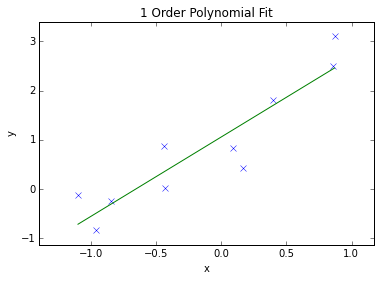

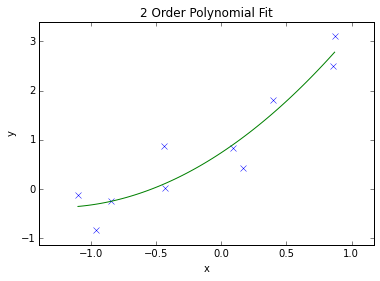

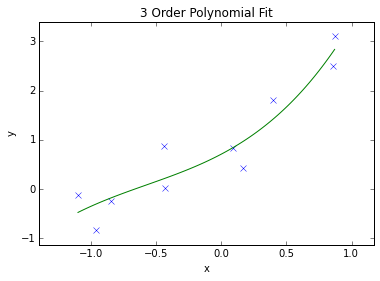

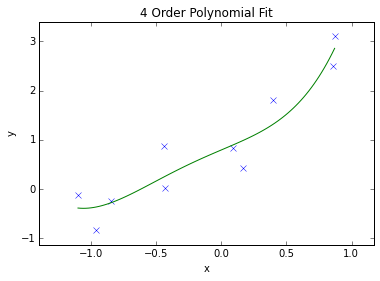

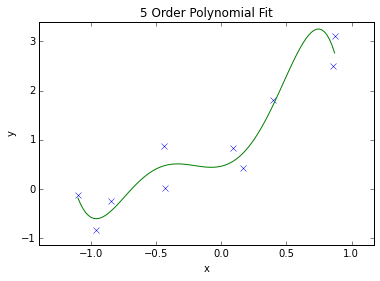

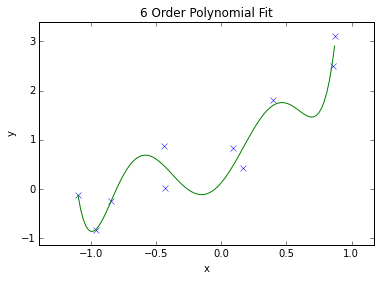

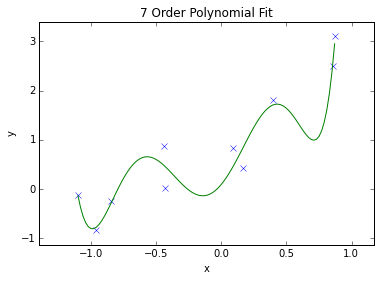

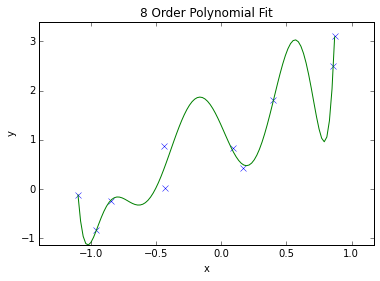

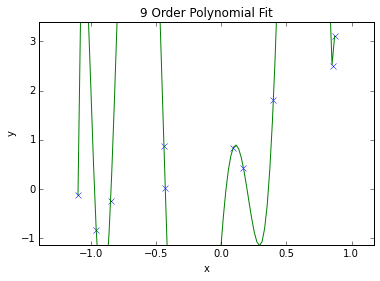

In [11]:
multifit(x,Y, plot=True, max_order=11)

The 9th order polynomial looks like a phenomenal fit. Why not check how much error it shows?

In [12]:
multifit(x,Y, return_findings=True, max_order=11, plot=False)[-1][2]

matrix([[  4.78685658e-16]])

That's a tiny error. However, just imagine if we have a new observation. Will our 9th order polynomial hypothesis $h_9$ generalize well? Probably not. The error on the *test* samples will be extremely high. Here our weights have "memorized" that data so well that they go through each of the training examples. How can we investigate this effect and make sure we pick the best order polynomial that generalizes well over a test set?

**True Error**: This is the error made by a hypothesis measured on all possible data points we can ever encounter.
However, in reality we do not have all possible observations. We woud need to do our best and measure our error over a training set.

Consider two hypothesis $h_1$ and $h_2$. Assume $h_1$ has a lower error on the training set. If $h_2$ has a lower *true* error than $h_1$, then we say that our algorithm is *overfitting*. 

**Explanation:**: We want our estimate of the true error (i.e test error) for $h_1$ to be higher than $h_1$ because know that it has the lower true error.



## Investigating the effect of overfitting on a testing set

To investigate this, the strategy we use is that we select a subset of our data to train on, and then use the other half as a testing set to estimate our error on. To do this we need more data.

In [13]:
def train_test_errors(x, y, max_order=11, print_out=False):
    all_data = zip(x,y) # data is first zipped into tuples so we do not loose positions of each data point
    
    #select a subset of the data
    np.random.shuffle(all_data)

    #divide the set into two.
    x_train,y_train = zip(*all_data[:len(all_data)/2])
    x_test, y_test = zip(*all_data[len(all_data)/2:])
    
    to_return = []
    
    multifit_results = multifit(x_train,y_train,plot=False, return_findings=True, max_order=max_order) # run a polyfit on our training set
    Y_test = np.matrix(y_test).T
    if print_out:
        print 'ORDER \t TRAIN ERROR \t TEST ERROR'
    for result in multifit_results:
        w_estimate = result[1]
        X_check = ML.add_bias_term(create_poly_features(x_test, result[0]))
    #     print X_check.shape, Y_test.shape, w_estimate.shape
        MSE_test = ML.mean_squared_error(X_check, Y_test, w_estimate)[0]
        if print_out:
            print result[0], '\t',float(result[2]), '\t',float(MSE_test)
        to_return.append( ( result[0], float(result[2]), float(MSE_test) ) )
        #endif
    #endfor
    
    return np.array(to_return)
    

### Example 1:
Let us generate some data according to:
$$ f(x) = \sin(x) + N(0,1) $$

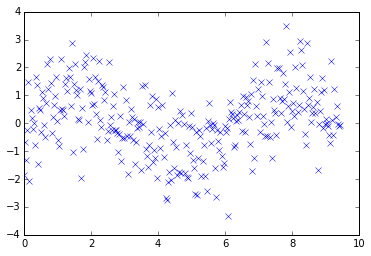

In [14]:
# creating some sinusoidal data with noise
x_new = np.linspace(0,3*pi, 300)
y_new = sin(x_new) + np.random.normal(loc=0, scale=1,size=len(x_new))
plt.plot(x_new,y_new, 'x')

In [15]:
tt_plot = train_test_errors(x_new, y_new, print_out=True,max_order=15)

ORDER 	 TRAIN ERROR 	 TEST ERROR
2 	194.501466211 	235.316765124
3 	174.721817429 	210.21066571
4 	174.69581948 	209.877701534
5 	133.74928101 	154.280214214
6 	133.5946402 	154.586103226
7 	131.272841658 	156.917270719
8 	130.426173188 	155.826957411
9 	130.215492531 	156.45446388
10 	130.023604006 	155.857976258
11 	128.859222283 	157.043901218
12 	127.918285106 	154.598066079
13 	143.081470771 	195.966615689
14 	195.967942091 	199.035765252


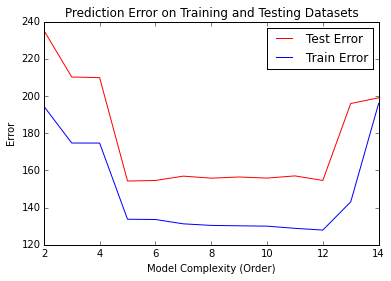

In [16]:
complexity, prediction_error_train, prediction_error_test =  tt_plot.T
plt.plot(complexity, prediction_error_test, 'r-', label='Test Error')
plt.plot(complexity, prediction_error_train, 'b-', label='Train Error')
plt.title('Prediction Error on Training and Testing Datasets')
plt.xlabel('Model Complexity (Order)')
plt.ylabel('Error')
plt.legend()

### Example 2:

Let us generate some linear data:

$$f(x) = 2 + x^2 + N(0,1)$$

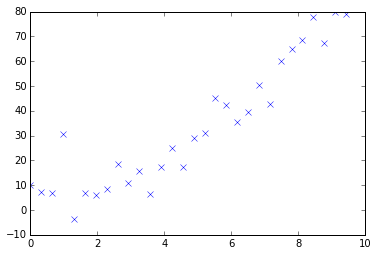

In [17]:
# creating some linear data with noise
x_new = np.linspace(0,3*pi, 30)
y_new = 2 + x_new**2 + np.random.normal(loc=0, scale=6,size=len(x_new))
plt.plot(x_new,y_new, 'x')

In [18]:
tt_plot = train_test_errors(x_new, y_new, print_out=True,max_order=12)

ORDER 	 TRAIN ERROR 	 TEST ERROR
2 	838.186526012 	2206.88837657
3 	362.006327497 	1630.55397279
4 	358.658146351 	1462.99483497
5 	351.595840819 	1868.57403553
6 	320.045658714 	4926.56135347
7 	319.573358543 	6328.22305399
8 	228.471415361 	92190.1512273
9 	228.201708225 	131966.573612
10 	208.312930639 	3526091.37621
11 	26495.1791922 	2479880.20106


Maybe we should plot this to make it more striking?

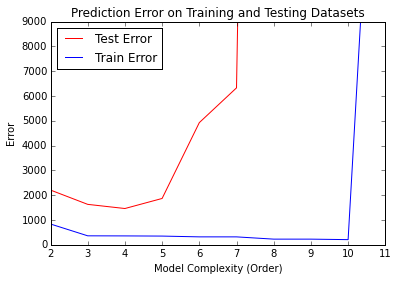

In [23]:
complexity, prediction_error_train, prediction_error_test =  tt_plot.T
plt.plot(complexity, prediction_error_test, 'r-', label='Test Error')
plt.plot(complexity, prediction_error_train, 'b-', label='Train Error')
plt.title('Prediction Error on Training and Testing Datasets')
plt.xlabel('Model Complexity (Order)')
plt.ylabel('Error')
plt.ylim([0,9000])
plt.legend(loc='upper left')

To the left of our graph we have models which display a high bias but low variance (i.e they do not vary much from their predictions but are systematically over estimated or under estimated.

To the right of our graph we have models which display low bias but high variance. 

#### Understanding the Error

- When we consider only the class of linear hypothesis, we have a systematic prediction error called *Bias* (Unless the data is generated by a linear function)
- If the true solution is from a linear class of functions we may get different solutions depending on the observed data, this is error due to the variance.

## Cross Validation
How can we compare our space hypothesis to prevent overfitting? 

We partition the training set $X,Y$ into $k$ equal subsets. For each hypothesis, we apply our algorithm $k$ times where each time we set aside one of the subsets and use the other data to find $\hat{w}$ and then measure the prediction error on the held out subset. After this we average the prediciton over the $k$ rounds for each order. We then choose the order with the lowest estimate of the true prediction error. 

**Downside:** Our compitational cost has increased $k$ times.

In [20]:
if type(ks) == int:
    ks = range(1,ks+1)

for k in ks:
    x_subsets = np.split(x_new, k) #split our array k ways
    

NameError: name 'ks' is not defined